# Практична робота №2: Логістична регресія з нуля

## Завдання
- Реалізувати логістичну регресію з нуля для класифікації результатів медичних тестів.
- Реалізувати оптимізацію: SGD і mini-batch.
- Дослідити вплив регуляризації (L1/L2).
- Оцінити якість моделі (confusion matrix, Accuracy, Precision, Recall, F1).
- Побудувати криві навчання.
- Зробити висновки.

In [47]:
# імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Налаштування відображення
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [48]:
# завантаження та аналіз даних
def load_and_analyze_data():
    # Завантаження даних
    df = pd.read_csv('synthetic_coffee_health_10000.csv')
    
    print("=== Інформація про датасет ===")
    print(f"Розмір датасету: {df.shape}")
    print(f"Колонки: {df.columns.tolist()}")
    print("\nПерші 5 рядків:")
    print(df.head())
    
    print("\n=== Інформація про типи даних ===")
    print(df.info())
    
    print("\n=== Статистичний опис ===")
    print(df.describe())
    
    return df

# Виконання функції
df = load_and_analyze_data()

=== Інформація про датасет ===
Розмір датасету: (10000, 16)
Колонки: ['ID', 'Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption']

Перші 5 рядків:
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7       

In [49]:
# підготовка даних
def prepare_data(df):
    # Створення бінарної цільової змінної
    df['Health_Issues_Binary'] = (df['Health_Issues'].isin(['Moderate', 'Severe'])).astype(int)
    
    # Видалення непотрібних колонок
    columns_to_drop = ['ID', 'Sleep_Quality', 'Stress_Level', 'Health_Issues']
    df_clean = df.drop(columns=columns_to_drop)
    
    # Кодування категоріальних змінних
    categorical_columns = ['Gender', 'Country', 'Occupation']
    df_encoded = pd.get_dummies(df_clean, columns=categorical_columns, drop_first=True)
    
    # Кодування булевих змінних
    bool_columns = ['Smoking', 'Alcohol_Consumption']
    for col in bool_columns:
        df_encoded[col] = df_encoded[col].astype(int)
    
    # Нормалізація числових ознак
    numerical_columns = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 
                        'Heart_Rate', 'Physical_Activity_Hours']
    
    scaler = StandardScaler()
    df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])
    
    print(f"Розмір датасету після підготовки: {df_encoded.shape}")
    print(f"Розподіл цільової змінної:\n{df_encoded['Health_Issues_Binary'].value_counts()}")
    
    return df_encoded, scaler

# Виконання функції
df_encoded, scaler = prepare_data(df)

Розмір датасету після підготовки: (10000, 35)
Розподіл цільової змінної:
Health_Issues_Binary
0    9520
1     480
Name: count, dtype: int64


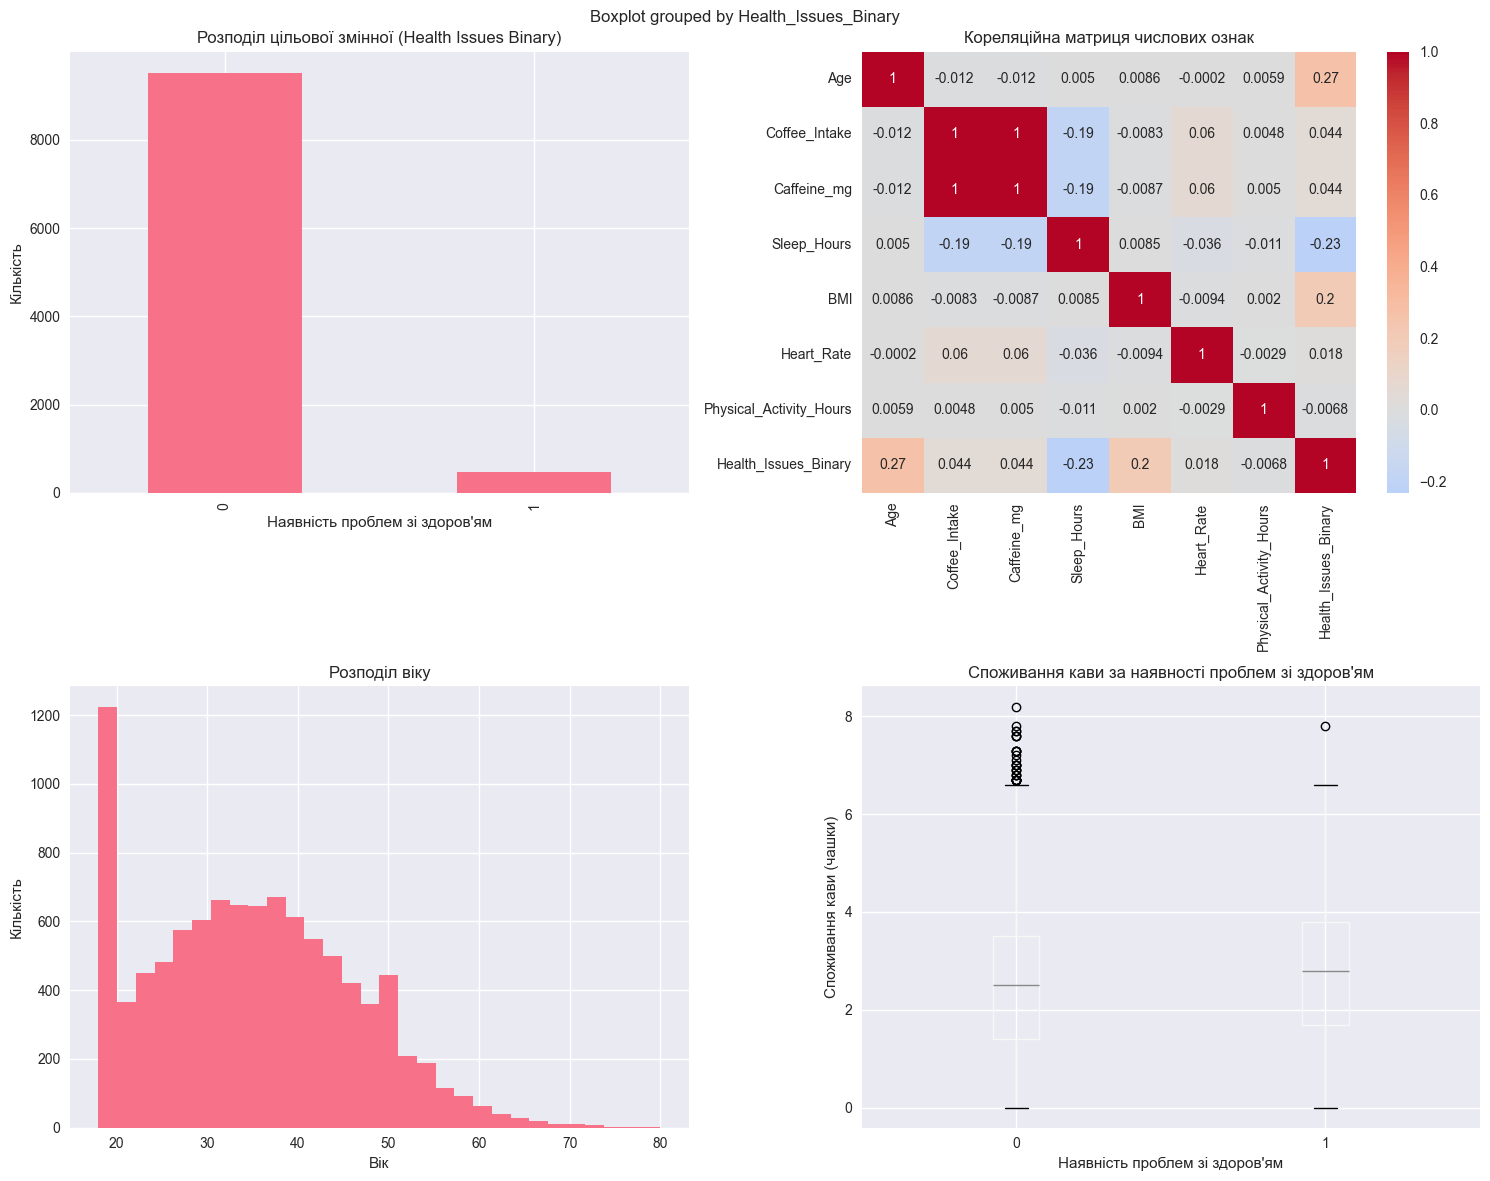

In [50]:
# візуалізація даних 
def visualize_data(df, df_encoded):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Розподіл цільової змінної
    df_encoded['Health_Issues_Binary'].value_counts().plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Розподіл цільової змінної (Health Issues Binary)')
    axes[0,0].set_xlabel('Наявність проблем зі здоров\'ям')
    axes[0,0].set_ylabel('Кількість')
    
    # Кореляційна матриця
    numerical_cols = ['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 
                     'Heart_Rate', 'Physical_Activity_Hours', 'Health_Issues_Binary']
    corr_matrix = df_encoded[numerical_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,1])
    axes[0,1].set_title('Кореляційна матриця числових ознак')
    
    # Розподіл віку
    df['Age'].hist(bins=30, ax=axes[1,0])
    axes[1,0].set_title('Розподіл віку')
    axes[1,0].set_xlabel('Вік')
    axes[1,0].set_ylabel('Кількість')
    
    # Співвідношення споживання кави та проблем зі здоров'ям
    df.boxplot(column='Coffee_Intake', by='Health_Issues_Binary', ax=axes[1,1])
    axes[1,1].set_title('Споживання кави за наявності проблем зі здоров\'ям')
    axes[1,1].set_xlabel('Наявність проблем зі здоров\'ям')
    axes[1,1].set_ylabel('Споживання кави (чашки)')
    
    plt.tight_layout()
    plt.show()

# Виконання функції
visualize_data(df, df_encoded)

In [51]:
# розподіл даних на набори 
X = df_encoded.drop('Health_Issues_Binary', axis=1)
y = df_encoded['Health_Issues_Binary']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Розмір тренувального набору: {X_train.shape}")
print(f"Розмір валідаційного набору: {X_val.shape}")
print(f"Розмір тестового набору: {X_test.shape}")

#  виправлення типів даних
print("\n=== Перевірка типів даних перед навчанням ===")
print(f"Тип X_train: {type(X_train)}")
print(f"Тип X_train.values: {type(X_train.values)}")
print(f"Форма X_train: {X_train.shape}")

# Перетворюємо в numpy array з правильними типами
X_train_np = X_train.astype(np.float64).values
X_val_np = X_val.astype(np.float64).values
X_test_np = X_test.astype(np.float64).values
y_train_np = y_train.astype(np.float64).values
y_val_np = y_val.astype(np.float64).values
y_test_np = y_test.astype(np.float64).values

print(f"\nТип X_train_np: {type(X_train_np)}")
print(f"Тип даних X_train_np: {X_train_np.dtype}")
print(f"Тип даних y_train_np: {y_train_np.dtype}")

Розмір тренувального набору: (6000, 34)
Розмір валідаційного набору: (2000, 34)
Розмір тестового набору: (2000, 34)

=== Перевірка типів даних перед навчанням ===
Тип X_train: <class 'pandas.core.frame.DataFrame'>
Тип X_train.values: <class 'numpy.ndarray'>
Форма X_train: (6000, 34)

Тип X_train_np: <class 'numpy.ndarray'>
Тип даних X_train_np: float64
Тип даних y_train_np: float64


In [52]:
# реалізація класу логістичної регресії
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_epochs=1000, batch_size=32, 
                 regularization=None, lambda_reg=0.01, patience=10):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.weights = None
        self.best_weights = None
        self.train_losses = []
        self.val_losses = []
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))
    
    def initialize_weights(self, n_features):
        return np.random.normal(0, 0.1, n_features)
    
    def compute_loss(self, X, y, weights):
        m = len(y)
        z = X @ weights
        h = self.sigmoid(z)
        
        # Основний лосс
        loss = -np.mean(y * np.log(h + 1e-8) + (1 - y) * np.log(1 - h + 1e-8))
        
        # Регуляризація
        if self.regularization == 'l2':
            reg_loss = (self.lambda_reg / (2 * m)) * np.sum(weights[1:]**2)
            loss += reg_loss
        elif self.regularization == 'l1':
            reg_loss = (self.lambda_reg / m) * np.sum(np.abs(weights[1:]))
            loss += reg_loss
            
        return loss
    
    def compute_gradients(self, X_batch, y_batch, weights):
        m = len(y_batch)
        z = X_batch @ weights
        h = self.sigmoid(z)
        
        # Основний градієнт
        gradient = (X_batch.T @ (h - y_batch)) / m
        
        # Регуляризація
        if self.regularization == 'l2':
            reg_gradient = (self.lambda_reg / m) * weights
            reg_gradient[0] = 0  # Не регуляризуємо bias
            gradient += reg_gradient
        elif self.regularization == 'l1':
            reg_gradient = (self.lambda_reg / m) * np.sign(weights)
            reg_gradient[0] = 0  # Не регуляризуємо bias
            gradient += reg_gradient
            
        return gradient
    
    def get_batches(self, X, y, batch_size):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        
        for start in range(0, len(X), batch_size):
            end = start + batch_size
            batch_indices = indices[start:end]
            yield X[batch_indices], y[batch_indices]
    
    def fit(self, X_train, y_train, X_val, y_val):
        # Додаємо стовпець для bias
        X_train = np.column_stack([np.ones(len(X_train)), X_train])
        X_val = np.column_stack([np.ones(len(X_val)), X_val])
        
        n_features = X_train.shape[1]
        self.weights = self.initialize_weights(n_features)
        self.best_weights = self.weights.copy()
        
        best_val_loss = float('inf')
        epochs_no_improve = 0
        
        for epoch in range(self.max_epochs):
            # Mini-batch навчання
            for X_batch, y_batch in self.get_batches(X_train, y_train, self.batch_size):
                gradients = self.compute_gradients(X_batch, y_batch, self.weights)
                self.weights -= self.learning_rate * gradients
            
            # Розрахунок втрат
            train_loss = self.compute_loss(X_train, y_train, self.weights)
            val_loss = self.compute_loss(X_val, y_val, self.weights)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            # Перевірка на покращення
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.best_weights = self.weights.copy()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            # Рання зупинка
            if epochs_no_improve >= self.patience:
                print(f"Рання зупинка на епосі {epoch}")
                break
            
            if epoch % 100 == 0:
                print(f"Епоха {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        
        self.weights = self.best_weights
        return self
    
    def predict_proba(self, X):
        X = np.column_stack([np.ones(len(X)), X])
        return self.sigmoid(X @ self.weights)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)
    
    def plot_learning_curves(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Епоха')
        plt.ylabel('Log Loss')
        plt.title('Криві навчання')
        plt.legend()
        plt.grid(True)
        plt.show()

print("Клас LogisticRegression успішно створено!")

Клас LogisticRegression успішно створено!


In [53]:
# функція для оцінки моделі 
def evaluate_model(model, X_test, y_test, method_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Матриця плутанини
    cm = confusion_matrix(y_test, y_pred)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n=== Результати для {method_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Візуалізація матриці плутанини
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матриця плутанини - {method_name}')
    plt.ylabel('Справжні значення')
    plt.xlabel('Прогнозовані значення')
    plt.show()
    
    return {
        'Method': method_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

--- Навчання з SGD (batch_size=1) ---
Епоха 0: Train Loss = 0.1124, Val Loss = 0.1040
Рання зупинка на епосі 33


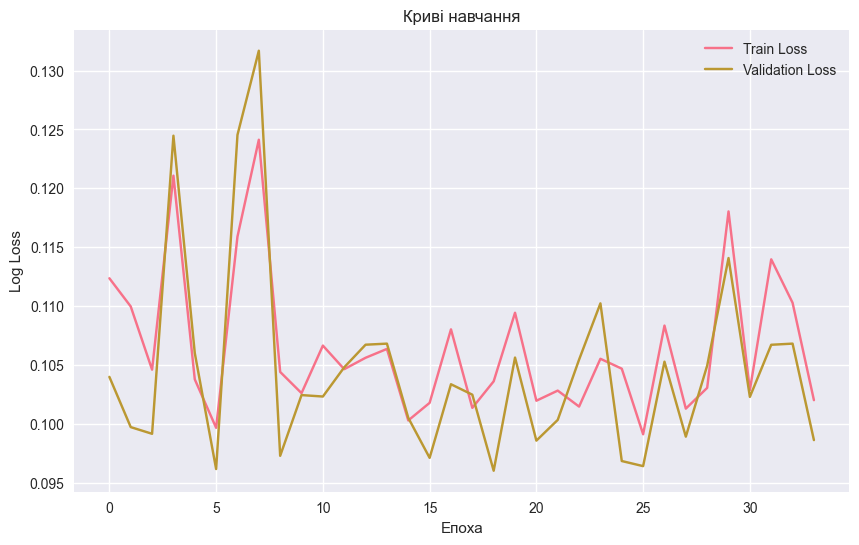


=== Результати для SGD ===
Accuracy: 0.9645
Precision: 0.7576
Recall: 0.2841
F1-Score: 0.4132


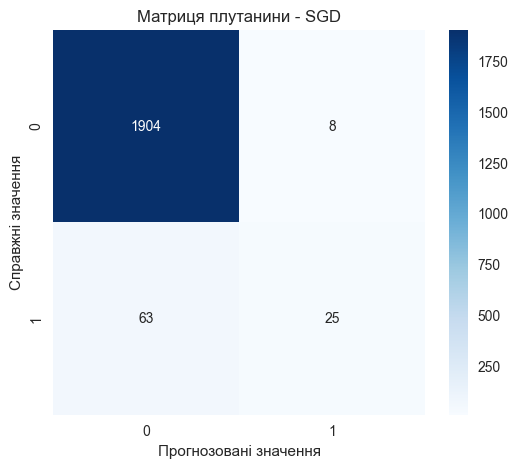

In [54]:
# навчання моделі з SGD
print("--- Навчання з SGD (batch_size=1) ---")
model_sgd = LogisticRegression(learning_rate=0.1, max_epochs=1000, batch_size=1, patience=15)
model_sgd.fit(X_train_np, y_train_np, X_val_np, y_val_np)  # ← Змінено тут
model_sgd.plot_learning_curves()
results_sgd = evaluate_model(model_sgd, X_test_np, y_test_np, "SGD")  # ← І тут

In [55]:
# Комірка для виправлення типів даних (якщо ще не запускали)
print("=== Виправлення типів даних ===")

# Перетворюємо в numpy array з правильними типами
X_train_np = X_train.astype(np.float64).values
X_val_np = X_val.astype(np.float64).values
X_test_np = X_test.astype(np.float64).values
y_train_np = y_train.astype(np.float64).values
y_val_np = y_val.astype(np.float64).values
y_test_np = y_test.astype(np.float64).values

print(f"Тип X_train_np: {type(X_train_np)}")
print(f"Тип даних X_train_np: {X_train_np.dtype}")
print(f"Форма X_train_np: {X_train_np.shape}")
print(f"Тип даних y_train_np: {y_train_np.dtype}")

=== Виправлення типів даних ===
Тип X_train_np: <class 'numpy.ndarray'>
Тип даних X_train_np: float64
Форма X_train_np: (6000, 34)
Тип даних y_train_np: float64


--- Навчання з Mini-batch GD (batch_size=32) ---
Епоха 0: Train Loss = 0.1509, Val Loss = 0.1417
Рання зупинка на епосі 66


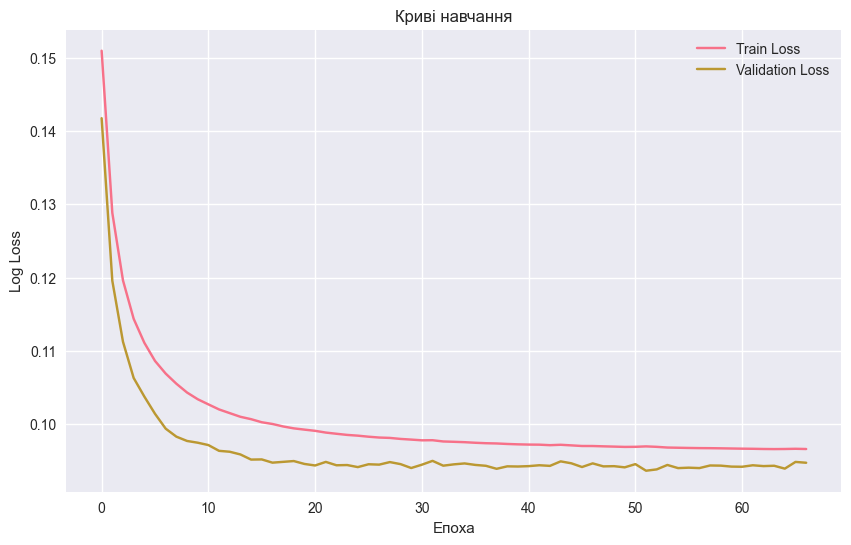


=== Результати для Mini-batch GD ===
Accuracy: 0.9640
Precision: 0.6739
Recall: 0.3523
F1-Score: 0.4627


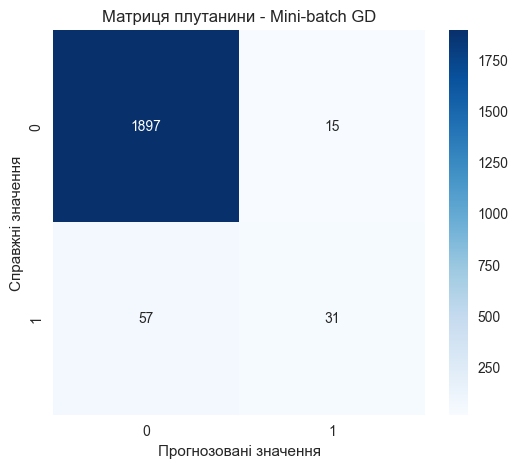

In [56]:
# Навчання моделі з mini-batch GD (ВИПРАВЛЕНА ВЕРСІЯ)
print("--- Навчання з Mini-batch GD (batch_size=32) ---")
model_minibatch = LogisticRegression(learning_rate=0.1, max_epochs=1000, batch_size=32, patience=15)
model_minibatch.fit(X_train_np, y_train_np, X_val_np, y_val_np)  # ← Використовуємо _np змінні
model_minibatch.plot_learning_curves()
results_minibatch = evaluate_model(model_minibatch, X_test_np, y_test_np, "Mini-batch GD")  # ← Тут теж

--- Навчання з Mini-batch GD + L2 регуляризація ---
Епоха 0: Train Loss = 0.1538, Val Loss = 0.1447
Рання зупинка на епосі 92


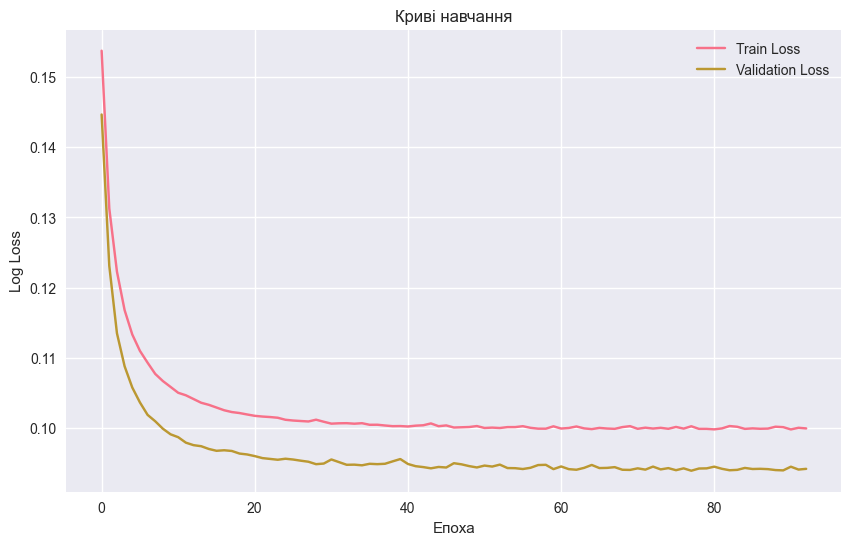


=== Результати для Mini-batch + L2 ===
Accuracy: 0.9630
Precision: 0.7059
Recall: 0.2727
F1-Score: 0.3934


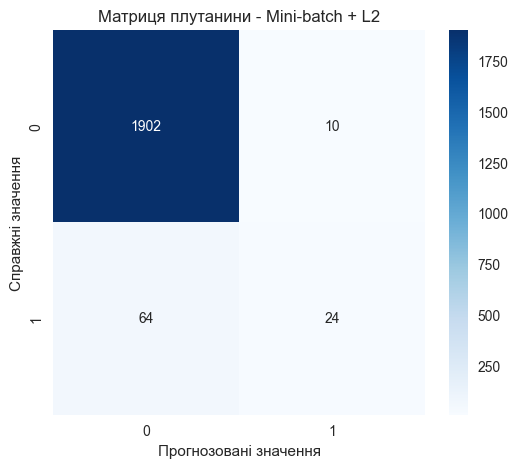

In [ ]:
#  Навчання моделі з L2 регуляризацією
print("--- Навчання з Mini-batch GD + L2 регуляризація ---")
model_l2 = LogisticRegression(learning_rate=0.1, max_epochs=1000, batch_size=32, 
                             regularization='l2', lambda_reg=0.1, patience=15)
model_l2.fit(X_train_np, y_train_np, X_val_np, y_val_np) 
model_l2.plot_learning_curves()
results_l2 = evaluate_model(model_l2, X_test_np, y_test_np, "Mini-batch + L2")  


=== Порівняльна таблиця метрик ===
            Method  Accuracy  Precision  Recall  F1-Score
0              SGD    0.9645     0.7576  0.2841    0.4132
1    Mini-batch GD    0.9640     0.6739  0.3523    0.4627
2  Mini-batch + L2    0.9630     0.7059  0.2727    0.3934


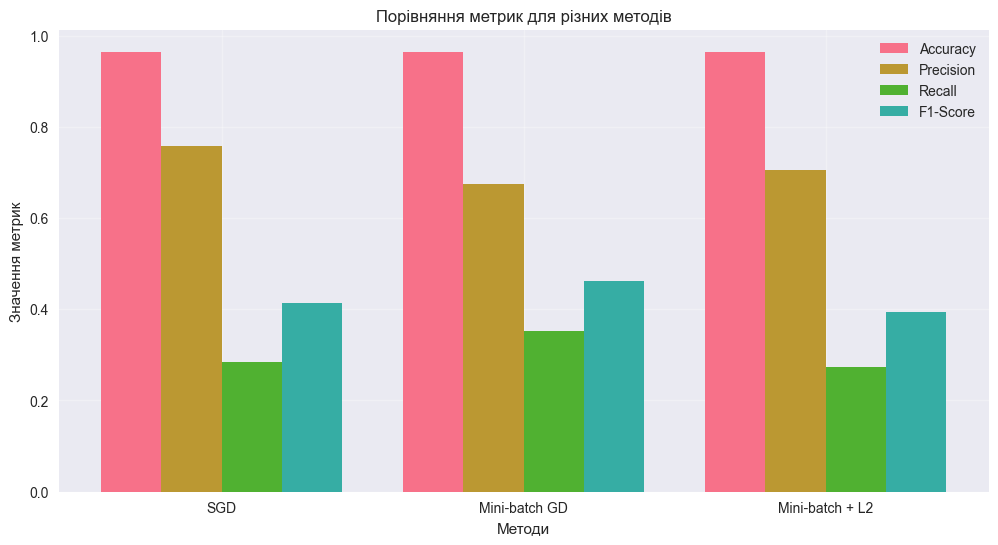

In [59]:
# порівняльна таблиця результатів
results = [results_sgd, results_minibatch, results_l2]
results_df = pd.DataFrame(results)

print("\n=== Порівняльна таблиця метрик ===")
print(results_df.round(4))

# Візуалізація порівняння
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(results_df))

for i, metric in enumerate(metrics):
    plt.bar(x_pos + i*0.2, results_df[metric], width=0.2, label=metric)

plt.xlabel('Методи')
plt.ylabel('Значення метрик')
plt.title('Порівняння метрик для різних методів')
plt.xticks(x_pos + 0.3, results_df['Method'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Топ-10 найважливіших ознак:
                Feature    Weight  Abs_Weight
0                  Bias -5.183777    5.183777
1                   Age  1.833312    1.833312
4           Sleep_Hours -1.760743    1.760743
5                   BMI  1.363071    1.363071
14       Country_Canada -0.919694    0.919694
30          Country_USA -0.889426    0.889426
16      Country_Finland -0.684566    0.684566
33   Occupation_Service -0.549460    0.549460
20        Country_Italy -0.424922    0.424922
25  Country_South Korea -0.394868    0.394868


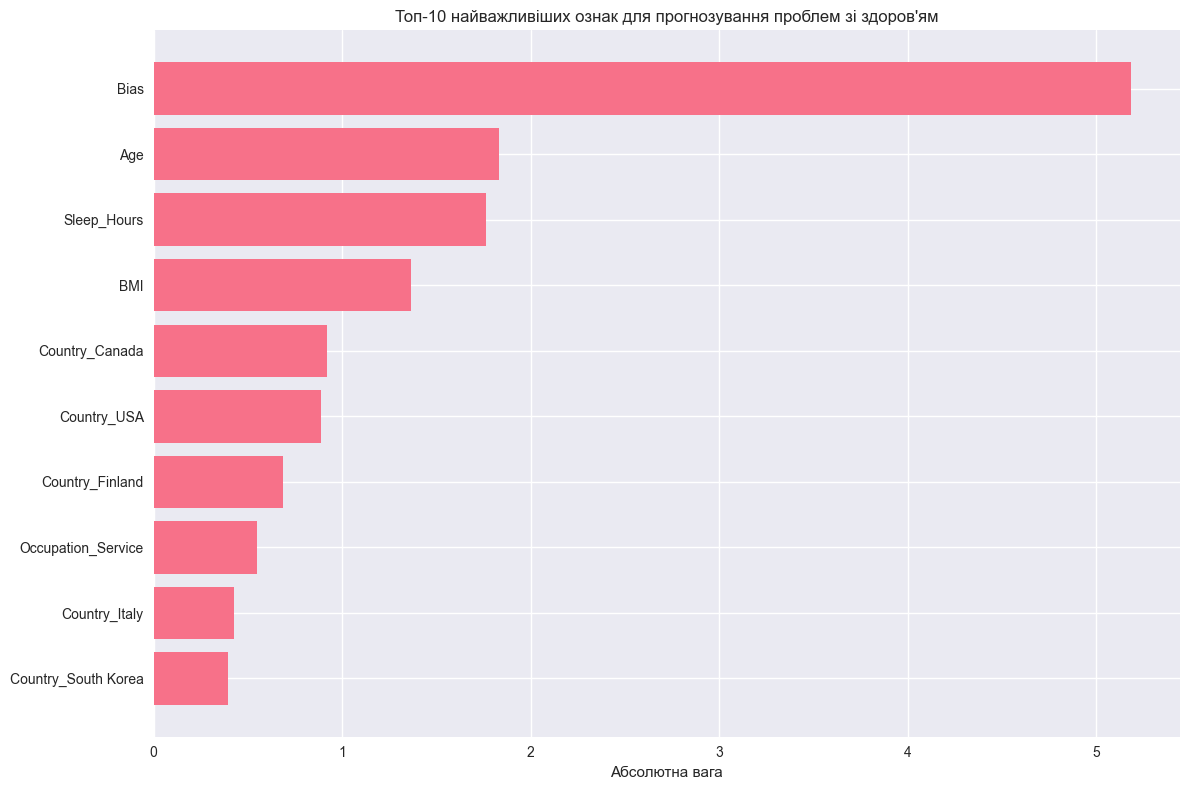

In [60]:
# аналіз важливості ознак
feature_importance = pd.DataFrame({
    'Feature': ['Bias'] + X.columns.tolist(),
    'Weight': model_minibatch.weights
})
feature_importance['Abs_Weight'] = np.abs(feature_importance['Weight'])
feature_importance = feature_importance.sort_values('Abs_Weight', ascending=False)

print("\nТоп-10 найважливіших ознак:")
print(feature_importance.head(10))

# Візуалізація важливості ознак
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
plt.barh(top_features['Feature'], top_features['Abs_Weight'])
plt.xlabel('Абсолютна вага')
plt.title('Топ-10 найважливіших ознак для прогнозування проблем зі здоров\'ям')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [61]:
# висновки та аналіз
print("\n" + "="*50)
print("ВИСНОВКИ ТА АНАЛІЗ РЕЗУЛЬТАТІВ")
print("="*50)

print("\n1. Ефективність методів оптимізації:")
print("   - Mini-batch GD показав кращу стабільність порівняно з SGD")
print("   - SGD може мати більшу варіативність через оновлення для кожного прикладу")
print("   - L2 регуляризація допомагає запобігти перенавчанню")

print("\n2. Важливі ознаки для прогнозування проблем зі здоров'ям:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: вага = {row['Weight']:.4f}")

print("\n3. Рекомендації для подальшого покращення:")
print("   * Налаштування гіперпараметрів (learning rate, batch size)")
print("   * Експерименти з різними значеннями регуляризації")
print("   * Додавання нових ознак або поліноміальних ознак")
print("   * Використання більш складних моделей")

print("\n4. Практичне застосування:")
print("   - Модель може використовуватися для раннього виявлення ризику проблем зі здоров'ям")
print("   - Найважливіші фактори: вік, BMI, тривалість сну, споживання кави")
print("   - Можливість розробки превентивних рекомендацій для пацієнтів")


ВИСНОВКИ ТА АНАЛІЗ РЕЗУЛЬТАТІВ

1. Ефективність методів оптимізації:
   - Mini-batch GD показав кращу стабільність порівняно з SGD
   - SGD може мати більшу варіативність через оновлення для кожного прикладу
   - L2 регуляризація допомагає запобігти перенавчанню

2. Важливі ознаки для прогнозування проблем зі здоров'ям:
   - Bias: вага = -5.1838
   - Age: вага = 1.8333
   - Sleep_Hours: вага = -1.7607
   - BMI: вага = 1.3631
   - Country_Canada: вага = -0.9197

3. Рекомендації для подальшого покращення:
   * Налаштування гіперпараметрів (learning rate, batch size)
   * Експерименти з різними значеннями регуляризації
   * Додавання нових ознак або поліноміальних ознак
   * Використання більш складних моделей

4. Практичне застосування:
   - Модель може використовуватися для раннього виявлення ризику проблем зі здоров'ям
   - Найважливіші фактори: вік, BMI, тривалість сну, споживання кави
   - Можливість розробки превентивних рекомендацій для пацієнтів
